In [37]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as pl

In [38]:
data = pd.read_csv('Data/properati.csv')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

## Resumen

1. Calcular % nulos por campo
2. Nueva variable surface_complete, combinando con la superficie cubierta en caso que superficie total sea nulo
2. Nueva variable new_price_usd_per_m2, calculando price_aprox_usd / surface_complete
3. Graficar % nulos por variable, por state_name y property_type
4. Graficar % nulos por variable, por state_name


### 1. Calcular % nulos por campo

In [40]:
nulls=data.apply(lambda x: x.notnull().sum())
total=data.shape[0]
percent_null =nulls.apply(lambda x:x/total).reset_index()
percent_null=percent_null.rename(columns={0:'pct_complete','index':'column'})
format_dict = {'sum':'${0:,.0f}', 'date': '{:%m-%Y}', 'pct_complete': '{:.2%}'}

(percent_null
     .style
     .format(format_dict)
     .hide_index()
     .bar(color='RoyalBlue', vmin=0, vmax=1,subset=['pct_complete'], align='zero')
     .set_caption('Percentage of Nulls'))



column,pct_complete
Unnamed: 0,100.00%
operation,100.00%
property_type,100.00%
place_name,99.98%
place_with_parent_names,100.00%
country_name,100.00%
state_name,100.00%
geonames_id,84.56%
lat-lon,57.47%
lat,57.47%


### 2. Nueva variable con superficie total completando por superficie cubierta

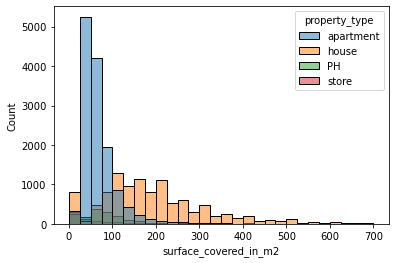

In [41]:
#Distribución de los datos que se usarían par completar
hue_order = ['apartment', 'house', 'PH','store']
sns.histplot(data=data[(data.surface_total_in_m2.isnull())], 
             x='surface_covered_in_m2', binwidth=25, 
             hue='property_type',
             binrange=(0,700),
                hue_order=hue_order);

<AxesSubplot:xlabel='surface_total_in_m2', ylabel='Count'>

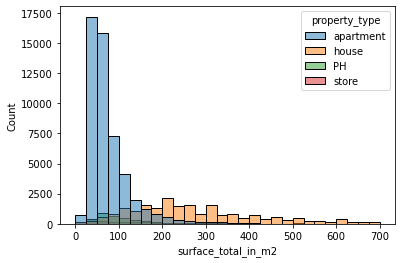

In [42]:
#Distribución original
hue_order = ['apartment', 'house', 'PH','store']
sns.histplot(data=data[data.surface_total_in_m2<700], x='surface_total_in_m2', binwidth=25, 
             hue='property_type',
            hue_order=hue_order,
            binrange=(0,700))

In [43]:
#Nueva serie con combinación de surface covered y surface total
surface_complete = data.apply(lambda x: x.surface_covered_in_m2 if pd.isna(x.surface_total_in_m2) else x.surface_total_in_m2, axis=1)
surface_complete.notnull().sum()/data.shape[0]

0.897962382445141

In [44]:
#Agregar al dataset
data['surface_complete']=surface_complete


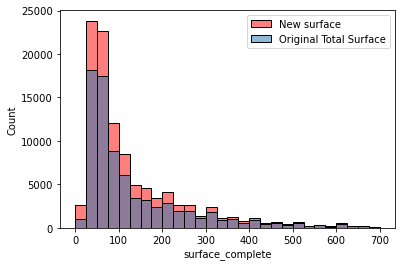

In [45]:
f=sns.histplot(data=data[data.surface_complete<700], x='surface_complete', 
               binwidth=25,binrange=(0,700),
               color='red',alpha=0.5)
f=sns.histplot(data=data[(data.surface_total_in_m2<700)],x='surface_total_in_m2', 
               binwidth=25,binrange=(0,700), 
               alpha=0.5)

f.legend(['New surface','Original Total Surface'])
f.plot();

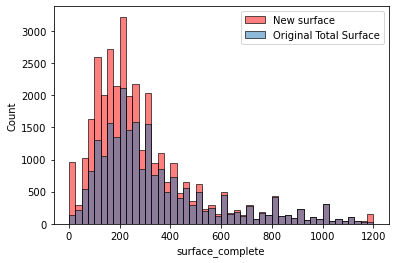

In [46]:
#Nueva Distribución para Casas
f=sns.histplot(data=data[(data.property_type=='house')], x='surface_complete', 
               binwidth=25, binrange=(0,1200),
               color='red',alpha=0.5)
f=sns.histplot(data=data[(data.surface_total_in_m2<1200)&(data.property_type=='house')],
               x='surface_total_in_m2', binwidth=25, binrange=(0,1200),
               alpha=0.5)

f.legend(['New surface','Original Total Surface'])
f.plot();

### 3.Nueva variable new_price_usd_per_m2, calculando price_aprox_usd / surface_complete

In [47]:
#Nueva columna precio/m2
data.loc[data.surface_complete>0,'new_price_usd_per_m2']=data.loc[data.surface_complete>0,'price_aprox_usd']/data.loc[data.surface_complete>0,'surface_complete']

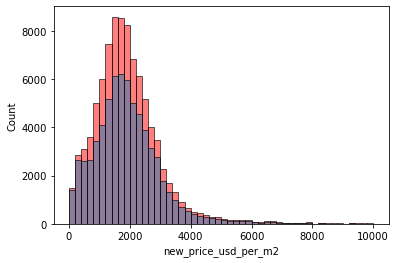

In [48]:
#new Precio/m2 total
sns.histplot(data=data[data.new_price_usd_per_m2<10000], x='new_price_usd_per_m2', binwidth=200, color='red',alpha=0.5)
sns.histplot(data=data[data.price_usd_per_m2<10000], x='price_usd_per_m2', binwidth=200, alpha=0.5);


In [49]:
list_price_m2_fields=['price_aprox_usd','price_usd_per_m2','price_per_m2','new_price_usd_per_m2','surface_covered_in_m2','surface_total_in_m2','surface_complete']

In [50]:
#Comparación de las distribuciones 
data[['price_per_m2','price_usd_per_m2','new_price_usd_per_m2','surface_covered_in_m2','surface_total_in_m2','surface_complete']].describe()

,price_per_m2,price_usd_per_m2,new_price_usd_per_m2,surface_covered_in_m2,surface_total_in_m2,surface_complete
count,8.765800e+04,68617.000000,9.292500e+04,101313.000000,81892.000000,108851.000000
mean,6.912216e+03,2160.086916,2.735903e+03,133.050181,233.795328,211.393878
std,2.837864e+04,2759.288621,1.729729e+04,724.351479,1782.222147,1656.437195
min,1.510204e+00,0.600000,6.000000e-01,0.000000,0.000000,0.000000
25%,1.550000e+03,1218.181818,1.236559e+03,45.000000,50.000000,50.000000
50%,2.213115e+03,1800.000000,1.800000e+03,75.000000,84.000000,83.000000
75%,3.355549e+03,2486.411765,2.475610e+03,150.000000,200.000000,190.000000
max,4.000000e+06,206333.333333,2.600000e+06,187000.000000,200000.000000,200000.000000


### 4.% Nulos por State

In [51]:
#Función para calcular las columans de % sobre el total
def calculate_percent(data_input, total):
    col_list=data_input.columns.drop(total)
    for i in col_list:
        col_name= '%null_'+i
        data_input[col_name]=data_input[i]/data_input[total]
    return data_input
    

In [52]:
#Dataset agrupado con % de nulos por state
null_state = data.groupby(['state_name'])[list_price_m2_fields].apply(lambda x: x.isnull().sum())
total_state = data.groupby(['state_name'])[['state_name']].count()
data_state=null_state.join(other=total_state)
data_state=data_state.rename(columns={'state_name':'total'})
data_state=calculate_percent(data_state,'total')
data_state=data_state.reset_index()

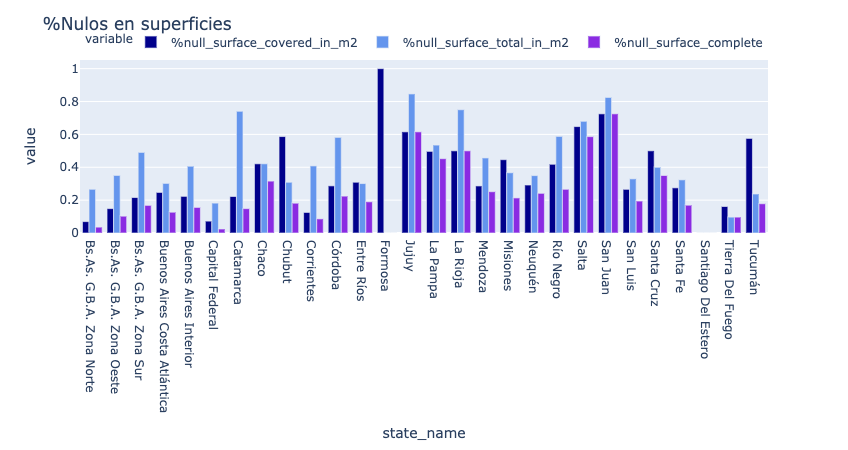

In [53]:
fig=px.bar(data_state, x='state_name', 
           y=['%null_surface_covered_in_m2','%null_surface_total_in_m2','%null_surface_complete'], 
           hover_data=['total'],
           barmode='group',
          color_discrete_sequence=['DarkBlue','CornFLowerBlue','BlueViolet'])

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,
), title='%Nulos en superficies')


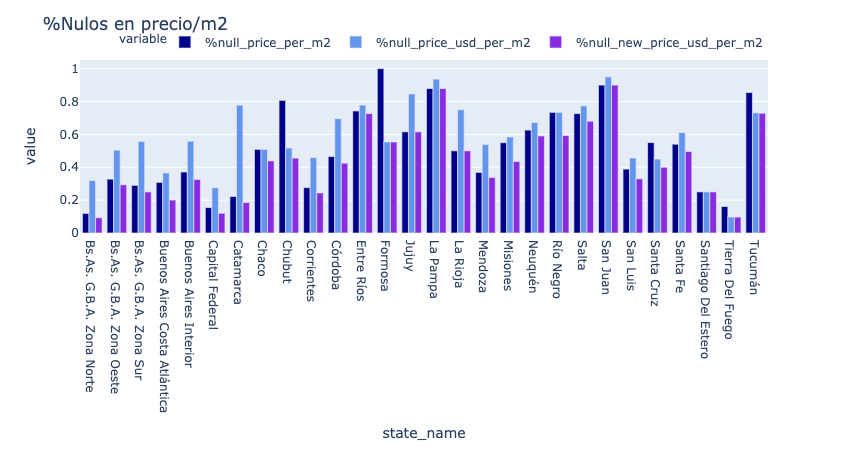

In [54]:
fig=px.bar(data_state, x='state_name', 
           y=['%null_price_per_m2','%null_price_usd_per_m2','%null_new_price_usd_per_m2'], 
           hover_data=['total'],
           barmode='group',
          color_discrete_sequence=['DarkBlue','CornFLowerBlue','BlueViolet'])

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
), title='%Nulos en precio/m2')


### % Nulos por State y Property Type

In [55]:
#Nulos por property type & state name
null_state_proptype = data.groupby(['property_type','state_name'])[list_price_m2_fields].apply(lambda x: x.isnull().sum())
null_state_proptype.head()

price_aprox_usd  price_usd_per_m2  \
property_type state_name                                                        
PH            Bs.As. G.B.A. Zona Norte                    7               360   
              Bs.As. G.B.A. Zona Oeste                   32               310   
              Bs.As. G.B.A. Zona Sur                     76               499   
              Buenos Aires Costa Atlántica               21               215   
              Buenos Aires Interior                       6                26   

                                            price_per_m2  \
property_type state_name                                   
PH            Bs.As. G.B.A. Zona Norte                81   
              Bs.As. G.B.A. Zona Oeste               159   
              Bs.As. G.B.A. Zona Sur                 219   
              Buenos Aires Costa Atlántica           186   
              Buenos Aires Interior                   15   

                                            new_price_usd_per_m2  \
property_type state_name                                           
PH            Bs.As. G.B.A. Zona Norte                        64   
              Bs.As. G.B.A. Zona Oeste                       137   
              Bs.As. G.B.A. Zona Sur                         189   
              Buenos Aires Costa Atlántica                   108   
              Buenos Aires Interior                           11   

                                            surface_covered_in_m2  \
property_type state_name                                            
PH            Bs.As. G.B.A. Zona Norte                         76   
              Bs.As. G.B.A. Zona Oeste                        141   
              Bs.As. G.B.A. Zona Sur                          205   
              Buenos Aires Costa Atlántica                    177   
              Buenos Aires Interior                            11   

                                            surface_total_in_m2  \
property_type state_name                                          
PH            Bs.As. G.B.A. Zona Norte                      351   
              Bs.As. G.B.A. Zona Oeste                      290   
              Bs.As. G.B.A. Zona Sur                        485   
              Buenos Aires Costa Atlántica                  208   
              Buenos Aires Interior                          23   

                                            surface_complete  
property_type state_name                                      
PH            Bs.As. G.B.A. Zona Norte                    54  
              Bs.As. G.B.A. Zona Oeste                   116  
              Bs.As. G.B.A. Zona Sur                     175  
              Buenos Aires Costa Atlántica                98  
              Buenos Aires Interior                        7

In [56]:
#Total por property type y state name
total_state_proptype = data.groupby(['property_type','state_name'])[['state_name']].count()
total_state_proptype.head()

state_name
property_type state_name                              
PH            Bs.As. G.B.A. Zona Norte             985
              Bs.As. G.B.A. Zona Oeste             789
              Bs.As. G.B.A. Zona Sur               821
              Buenos Aires Costa Atlántica         575
              Buenos Aires Interior                 48

In [57]:
#Check total
data.loc[data.state_name=='Bs.As. G.B.A. Zona Oeste'].loc[data.property_type=='PH'].shape[0]

789

In [58]:
#Check nulos
data.loc[data.state_name=='Bs.As. G.B.A. Zona Oeste'].loc[data.property_type=='PH']['price_aprox_usd'].isnull().sum()

32

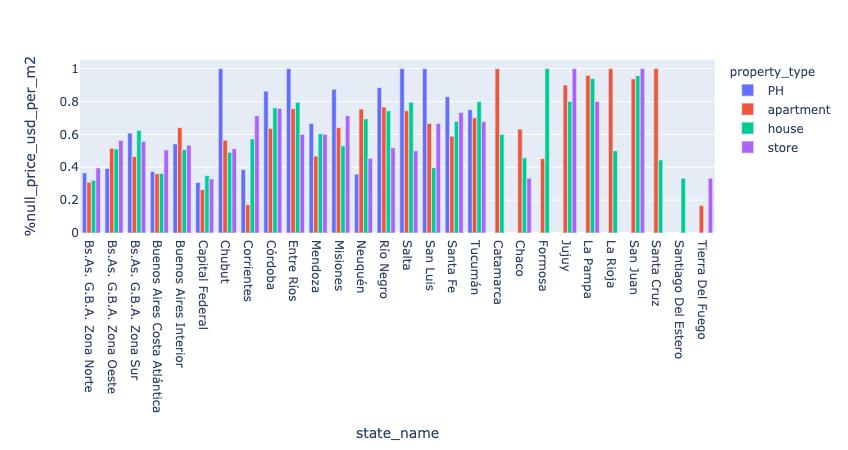

In [59]:
#Dataset con los nulos y el total agrupados por state y property type
data_state_proptype=null_state_proptype.join(other=total_state_proptype)
data_state_proptype=data_state_proptype.rename(columns={'state_name':'total'})
data_state_proptype=calculate_percent(data_state_proptype,'total')
data_state_proptype= data_state_proptype.reset_index()
px.bar(data_state_proptype, x='state_name',y='%null_price_usd_per_m2', color='property_type',barmode='group')

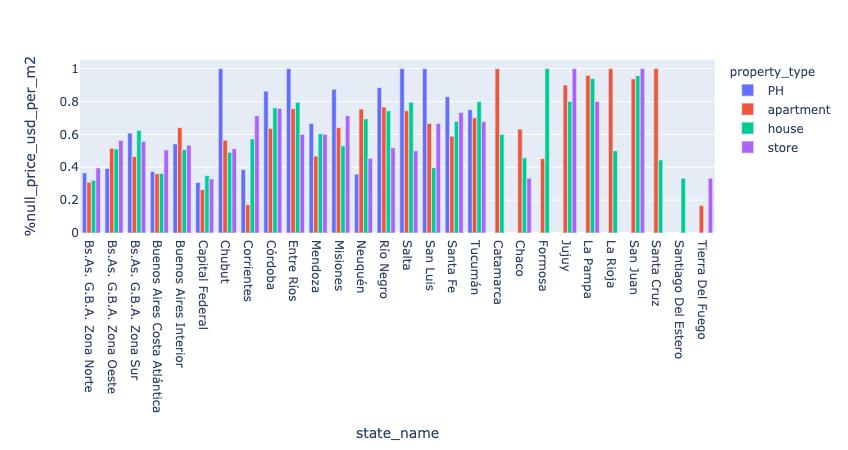

In [60]:
px.bar(data_state_proptype, x='state_name',y='%null_price_usd_per_m2', color='property_type',barmode='group')

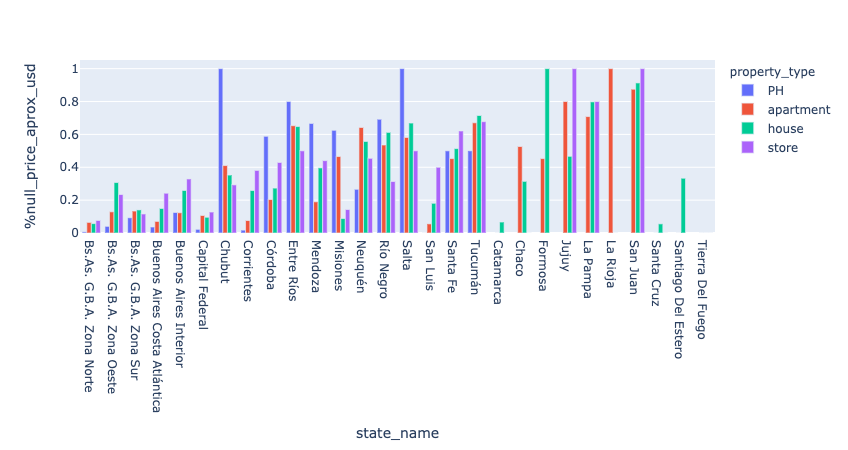

In [61]:
px.bar(data_state_proptype, x='state_name',y='%null_price_aprox_usd', color='property_type',barmode='group')


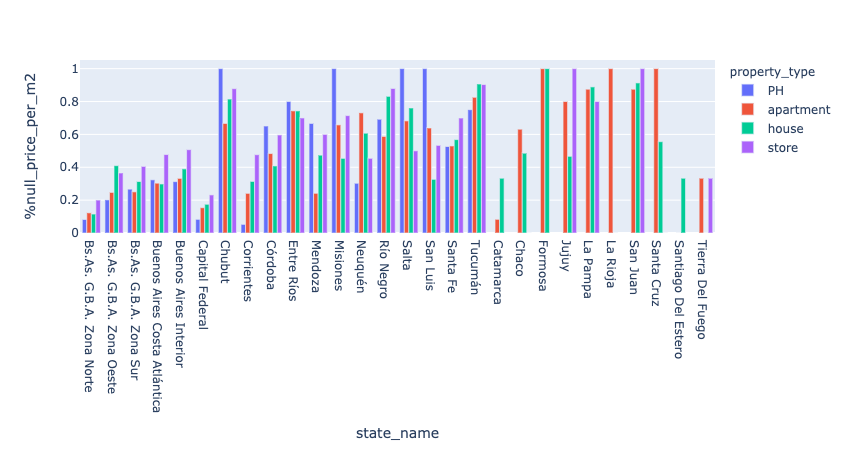

In [62]:
px.bar(data_state_proptype, x='state_name',y='%null_price_per_m2', color='property_type',barmode='group')

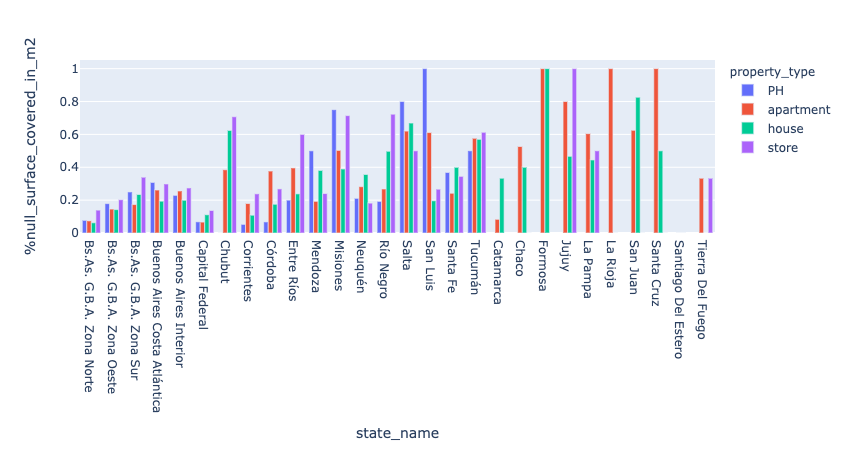

In [63]:
px.bar(data_state_proptype, x='state_name',y='%null_surface_covered_in_m2', color='property_type',
       hover_data=['total'] ,
       barmode='group')


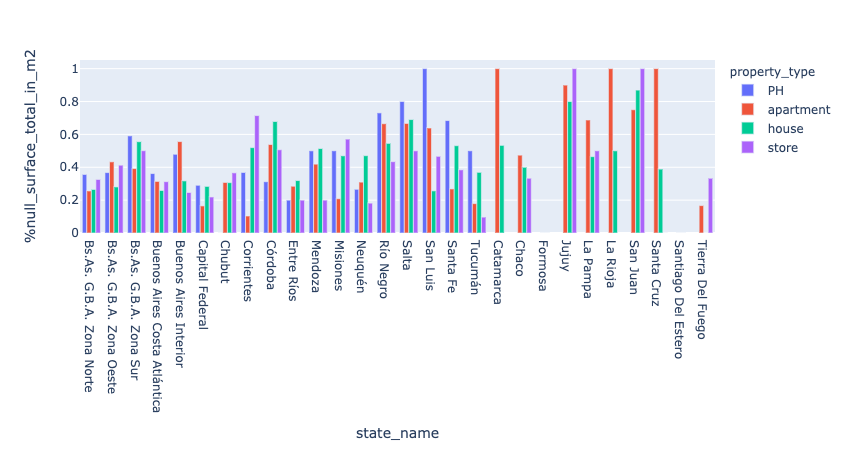

In [64]:
px.bar(data_state_proptype, x='state_name', y='%null_surface_total_in_m2', hover_data=['total'] , color='property_type',barmode='group')


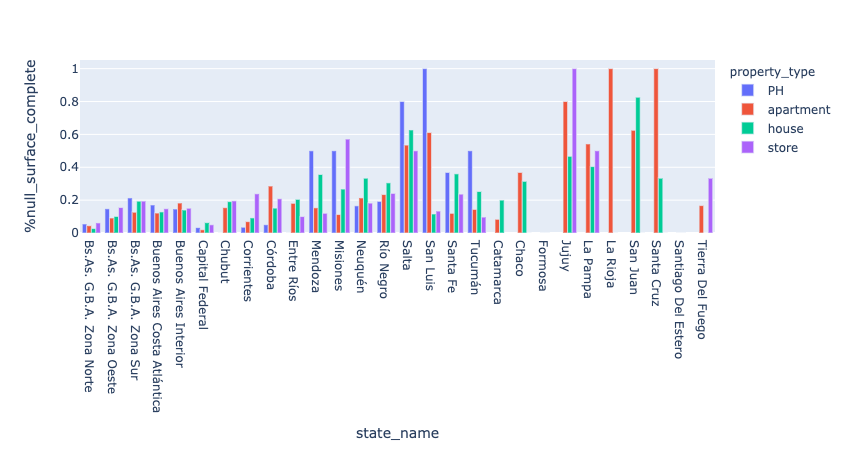

In [65]:
#% Registros completos con la combinación surface_covered & surface_total
px.bar(data_state_proptype, x='state_name', y='%null_surface_complete', hover_data=['total'] , color='property_type',barmode='group')


### Export

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

In [67]:
nulls=data.apply(lambda x: x.notnull().sum())
total=data.shape[0]
percent_null =nulls.apply(lambda x:x/total).reset_index()
percent_null=percent_null.rename(columns={0:'pct_complete','index':'column'})
format_dict = {'sum':'${0:,.0f}', 'date': '{:%m-%Y}', 'pct_complete': '{:.2%}'}

(percent_null
     .style
     .format(format_dict)
     .hide_index()
     .bar(color='RoyalBlue', vmin=0, vmax=1,subset=['pct_complete'], align='zero')
     .set_caption('Percentage of Nulls'))



column,pct_complete
Unnamed: 0,100.00%
operation,100.00%
property_type,100.00%
place_name,99.98%
place_with_parent_names,100.00%
country_name,100.00%
state_name,100.00%
geonames_id,84.56%
lat-lon,57.47%
lat,57.47%


In [68]:
data.to_csv('data_surface_price_expanded.csv')